In [15]:
import os
import numpy as np
import cv2
import scipy.io as sio
import PIL
import pydicom

import keras
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [11]:
train_dicom_dir = 'D:/_jiwon_/train/DICOM'
train_label_dir = 'D:/_jiwon_/train/Label'
test_dicom_dir = 'D:/_jiwon_/test/DICOM'

img_size = (512, 512)
num_classes = 2
batch_size = 2


train_dicom_paths = [
    os.path.join(path, filename) 
    for (path, dir, files) in os.walk(train_dicom_dir) 
    for filename in files 
    if os.path.splitext(filename)[-1] == '.dcm'
]

print('train DICOM :', len(train_dicom_paths), 'sets')


train_label_paths = [
    os.path.join(path, filename) 
    for (path, dir, files) in os.walk(train_label_dir) 
    for filename in files 
    if os.path.splitext(filename)[-1] == '.png'
]

print('train Label :', len(train_label_paths), 'sets')


test_dicom_paths = [
    os.path.join(path, filename) 
    for (path, dir, files) in os.walk(test_dicom_dir) 
    for filename in files 
    if os.path.splitext(filename)[-1] == '.dcm'
]

print('test DICOM :', len(test_dicom_paths), 'sets')


for dicom_path, label_path in zip(train_dicom_paths[-10:], train_label_paths[-10:]):
    print(dicom_path, "|", label_path)

train DICOM : 2722 sets
train Label : 2722 sets
test DICOM : 178 sets
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10143.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10143.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10144.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10144.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10145.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10145.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10146.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10146.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10147.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10147.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10148.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10148.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10149.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10149.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10150.dcm | D:/_jiwon_/train/Label\200225_Patient15_CT\10150.png
D:/_jiwon_/train/DICOM\200225_Patient15_CT\10151.dcm | D:/_jiwon_/

In [4]:
from tensorflow.keras.preprocessing.image import load_img

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_widht=400, window_level=60):    
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, train_dicom_dir, train_label_dir):
        self.batch_size = batch_size
        self.image_size = image_size
        self.train_dicom_paths = train_dicom_dir
        self.train_label_paths = train_label_dir
    
    def __len__(self):
        return len(self.train_dicom_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_train_dicom_paths = self.train_dicom_paths[i : i + self.batch_size]
        batch_train_label_paths = self.train_label_paths[i : i + self.batch_size]
        
        x = np.zeros((batch_size,) + self.image_size + (3, ), dtype='float32')
        for j, path in enumerate(batch_train_dicom_paths):
            # add augmenation dataset(*.jpg)
            if path[-3:] == 'jpg':
                image = cv2.imread(path)
            else:
                image = read_dicom(path) * 255
            x[j] = image
        
        y = np.zeros((batch_size,) + self.image_size + (num_classes,), dtype='float32')
        for j, path in enumerate(batch_train_label_paths):
            image = load_img(path, target_size=self.image_size, color_mode='grayscale')
            array = np.array(image)
            num = np.unique(array)
            num = num.shape[0]
            y[j] = np.eye(num)[array]
        return x, y

In [6]:
import random

val_samples = int(len(train_dicom_paths) * 0.1)
random.Random(1337).shuffle(train_dicom_paths)
random.Random(1337).shuffle(train_label_paths)

train_gen = DataGenerator(batch_size, img_size, train_dicom_paths[:-val_samples], train_label_paths[:-val_samples])
#print(train_gen[0][0][1].shape)
val_gen = DataGenerator(batch_size, img_size, train_dicom_paths[-val_samples:], train_label_paths[-val_samples:])

In [7]:
def make_colormask(class_data):
    img = PIL.Image.fromarray(class_data)

    mask_image = img.convert('RGBA')
    mask_pixel = mask_image.load()

    for i in range(mask_image.size[0]):
        for j in range(mask_image.size[1]):
            if mask_pixel[i, j] == (0, 0, 0, 255):
                mask_pixel[i, j] = (0, 0, 0, 0);
            elif mask_pixel[i, j] == (1, 1, 1, 255):
                mask_pixel[i, j] = (255, 0, 0, 128);
            elif mask_pixel[i, j] == (2, 2, 2, 255):
                mask_pixel[i, j] = (0, 255, 0, 128);
            elif mask_pixel[i, j] == (3, 3, 3, 255):
                mask_pixel[i, j] = (0, 0, 255, 128);
            else:
                mask_pixel[i, j] = (0, 0, 0, 0)
    return mask_image


def overlay_colormask_on_image(img, color_mask):
    return PIL.Image.alpha_composite(img.convert('RGBA'), color_mask) \
        .resize((img.size[0], img.size[1]), PIL.Image.ANTIALIAS)

In [8]:
'''
sample_rows = 6
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))

for ((ax1, ax2), dcm_path, label_path) in zip(m_axs, train_dicom_paths, train_label_paths):
    dcm_image = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))
    label_image = PIL.Image.open(label_path)
    
    ax1.imshow(dcm_image)
    ax1.set_title('DICOM image')

    color_mask = make_colormask(np.array(label_image)) 
    overlay_image = overlay_colormask_on_image(dcm_image, color_mask)
    
    ax2.imshow(overlay_image)
    ax2.set_title('Label overlay image')
'''

"\nsample_rows = 6\nfig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))\n\nfor ((ax1, ax2), dcm_path, label_path) in zip(m_axs, train_dicom_paths, train_label_paths):\n    dcm_image = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))\n    label_image = PIL.Image.open(label_path)\n    \n    ax1.imshow(dcm_image)\n    ax1.set_title('DICOM image')\n\n    color_mask = make_colormask(np.array(label_image)) \n    overlay_image = overlay_colormask_on_image(dcm_image, color_mask)\n    \n    ax2.imshow(overlay_image)\n    ax2.set_title('Label overlay image')\n"

In [9]:
def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))
    
    # 512
    down0a = Conv2D(16, (3, 3), padding='same')(inputs)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    
    # 256
    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    
    # 128
    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
    # 64
    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    
    # 32
    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    
    # 16
    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    
    # 8
    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    
    # center
    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    
    # 16
    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    
    # 32
    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    
    # 64
    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    
    # 128
    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    
    # 256
    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    
    # 512
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)

    model = Model(inputs, outputs)
    return model

In [10]:
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
from tensorflow.keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = tf.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
def dice_coef_multilabel(y_true, y_pred, num_labels = 4):
    dice = 0
    for index in range(num_labels):
        dice += (
        1 - dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        ) / num_labels
    return dice
def softmax_dice_loss(y_true, y_pred):
    index = tf.argmax(y_true, axis=-1)
    alpha = 1
    beta = 1
    return alpha * K.sparse_categorical_crossentropy(index, y_pred, from_logits=False) \
        + beta * dice_coef_multilabel(y_true, y_pred, 4)

In [12]:
model.compile(optimizer='rmsprop', loss=softmax_dice_loss)

callbacks = [
    keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
1845/1845 [==============================] - 241s 131ms/step - loss: 0.1843 - val_loss: 0.0650
Epoch 2/20
1845/1845 [==============================] - 240s 130ms/step - loss: 0.0495 - val_loss: 0.0472
Epoch 3/20
1845/1845 [==============================] - 241s 130ms/step - loss: 0.0431 - val_loss: 0.0420
Epoch 4/20
1845/1845 [==============================] - 241s 131ms/step - loss: 0.0398 - val_loss: 0.0391
Epoch 5/20
1845/1845 [==============================] - 242s 131ms/step - loss: 0.0370 - val_loss: 0.0369
Epoch 6/20
1845/1845 [==============================] - 240s 130ms/step - loss: 0.0344 - val_loss: 0.0378
Epoch 7/20
1845/1845 [==============================] - 239s 130ms/step - loss: 0.0323 - val_loss: 0.0327
Epoch 8/20
1845/1845 [==============================] - 242s 131ms/step - loss: 0.0304 - val_loss: 0.0318
Epoch 9/20
1845/1845 [==============================] - 241s 130ms/step - loss: 0.0290 - val_loss: 0.0304
Epoch 10/20
1845/1845 [=======================

In [13]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [14]:
from IPython.display import Image, display

preds = {}
for test_dicom_path in test_dicom_paths:
    test_image = read_dicom(test_dicom_path) * 255
    test_image = PIL.Image.fromarray(test_image.astype('uint8'))
    
    pred = model.predict(np.expand_dims(np.array(test_image), axis=0))
    class_data = np.argmax(pred.squeeze(), axis=-1).astype('uint8')
    
    filename = os.path.basename(test_dicom_path)
    preds[filename] = class_data

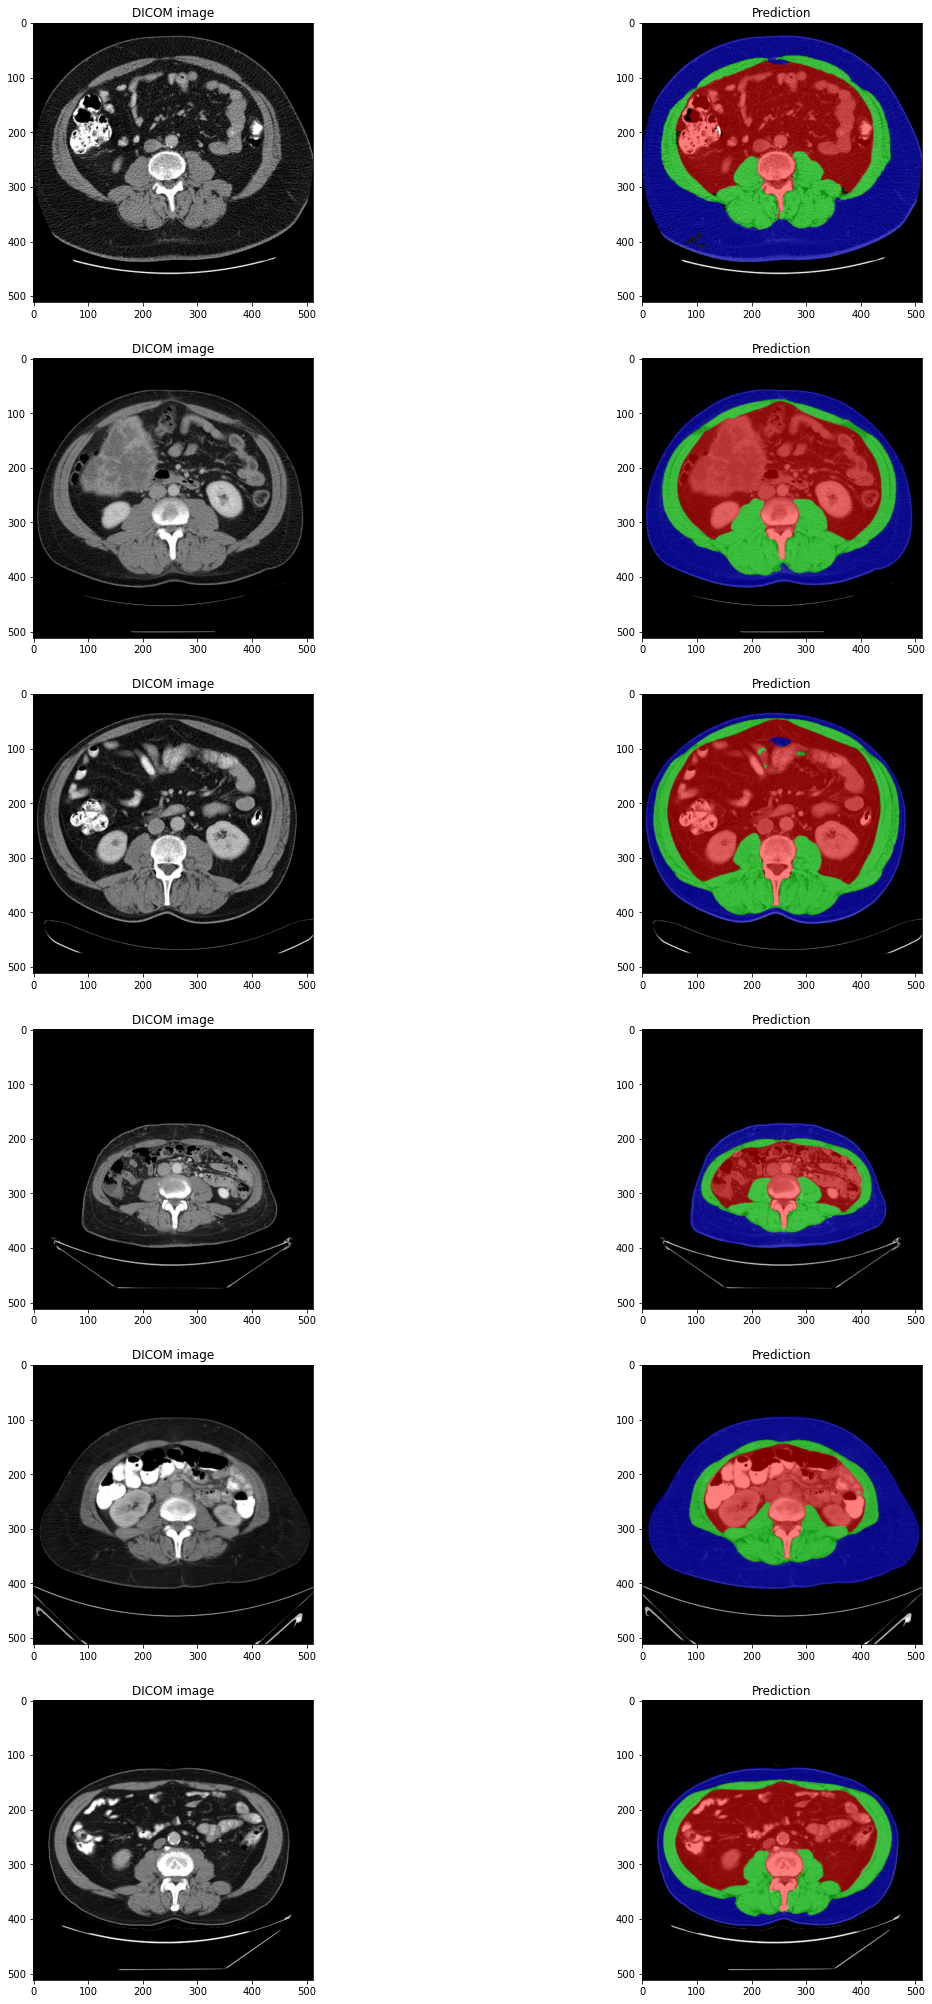

In [15]:
sample_rows = 6
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))

for (ax1, ax2), (filename, pred) in zip(m_axs, preds.items()):
    dcm_path = os.path.join(test_dicom_dir, filename)
    dcm_img = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))
    
    ax1.imshow(dcm_img)
    ax1.set_title('DICOM image')

    color_mask = make_colormask(pred) 
    overlay_img = overlay_colormask_on_image(dcm_img.convert('RGBA'), color_mask)
    
    ax2.imshow(overlay_img)
    ax2.set_title('Prediction')

In [16]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [17]:
imageIds = []
encodedPixels = []

for key, value in preds.items():
    filename, extension = os.path.splitext(key)
    for label_number in range(1, num_classes):  
        imageIds.append(f'{filename}_{label_number}')
        encodedPixels.append(str(list(rle_encode(np.equal(value, label_number))))[1:-1].strip().replace(',',''))

import pandas as pd
submission_df = pd.DataFrame({'ImageId': imageIds, 'EncodedPixels': encodedPixels})

In [18]:
submission_df.head()

,ImageId,EncodedPixels
0,case183_1,36578 5 37087 9 37132 3 37596 16 37645 4 38107...
1,case183_2,31494 30 32002 41 32513 47 33018 5 33024 51 33...
2,case183_3,12538 9 12549 18 13023 68 13526 81 14027 99 14...
3,case184_1,40697 10 41206 17 41715 22 42224 28 42735 32 4...
4,case184_2,38637 5 38643 10 38657 7 39141 37 39647 45 401...


In [19]:
submission_df.to_csv('./submission.csv',index=False)
from IPython.display import FileLink
FileLink('./submission.csv')

/kaggle/working/submission.csv